<a href="https://colab.research.google.com/github/Svatunek-Lab/teaching/blob/main/2025_University_of_Malaya_Intro_Chemistry_Python/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Molecules to Models – Machine Learning in Chemistry

In the previous sections, we learned how to:
- represent molecules using **SMILES** strings,
- visualize them in **2D and 3D**, and
- calculate **basic molecular descriptors** such as molecular weight or polar surface area.

Now we will take the next step:  
using those descriptors as **numerical features** in a simple **machine learning model**.

---

## What you will learn

1. Load a small dataset of organic molecules with known **experimental solubility**.  
2. Compute a few **physicochemical descriptors** using RDKit.  
3. Train a **regression model** (a Random Forest) to predict solubility from molecular structure.  
4. Evaluate the model and visualize how well it performs.

This is a simplified example of what computational and data-driven chemistry does at larger scales —  
transforming chemical intuition into quantitative models.

---

> *Goal:* Connect chemistry and data science — predicting molecular behavior from structure using only a few lines of Python.


##  Setup and Preparation

Firstwe have to install all necessary packages —  
**RDKit** for chemistry operations, **pandas** for data handling, **scikit-learn** for machine learning, and **matplotlib** for visualization —  
we are ready to start working with real chemical data.


In [2]:
!pip -q install pandas scikit-learn matplotlib
!pip install -q rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 48.6 MB/s eta 0:00:00


## The Solubility Dataset

In this section, we will use a small dataset of **organic molecules** with their **experimental aqueous solubility** (log S).

Each molecule is represented by its **SMILES** string (a text-based structure code), and the goal is to use this structural information to **predict solubility** using machine learning.

We will:
1. **Load** the dataset directly from this repository (stored in the `data` folder).  
2. **Inspect** the first few entries to understand what it contains.  
3. **Split** the data into three parts:
   - **Training set** → used to teach the model  
   - **Validation set** → used to tune and test during training  
   - **Test set** → used at the end to see how well the model generalizes

This is the same idea as in experimental chemistry:
> we “train” our model with known molecules, then test whether it can correctly predict unknown ones.


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
url = "https://raw.githubusercontent.com/Svatunek-Lab/teaching/main/2025_University_of_Malaya_Intro_Chemistry_Python/data/delaney-processed.csv"
df = pd.read_csv(url)
print("Column names:", df.columns.tolist())
print(f"Dataset shape: {df.shape}")

# Keep only the essential columns
df = df[["Compound ID", "measured log solubility in mols per litre", "smiles"]]
df.columns = ["name", "logS_exp", "smiles"]

# Split into train, validation, and test sets 70:15:15
train, temp = train_test_split(df, test_size=0.3, random_state=42)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)

print(f"Training set: {len(train)} molecules")
print(f"Validation set: {len(valid)} molecules")
print(f"Test set: {len(test)} molecules")

train.head()



Column names: ['Compound ID', 'measured log solubility in mols per litre', 'smiles']
Dataset shape: (1128, 3)
Training set: 789 molecules
Validation set: 169 molecules
Test set: 170 molecules


,name,logS_exp,smiles
930,Hexamethylbenzene,-5.230,Cc1c(C)c(C)c(C)c(C)c1C
670,"1,1,2-Trichlorotrifluoroethane",-3.040,FC(F)(Cl)C(F)(Cl)Cl
65,"Atovaquone(0,430mg/ml) - neutral",-5.931,OC4=C(C1CCC(CC1)c2ccc(Cl)cc2)C(=O)c3ccccc3C4=O
398,Mefenacet,-4.873,CN(C(=O)COc1nc2ccccc2s1)c3ccccc3
736,5-Methylchrysene,-6.590,c1cccc2c3c(C)cc4ccccc4c3ccc12


## Calculating Molecular Descriptors

Now that we have our training, validation, and test datasets ready,  
the next step is to **translate the SMILES strings into numerical properties** that capture chemical information.

Machine learning models cannot understand the letters and symbols in a SMILES string directly —  
they need numbers that describe what makes one molecule different from another.

These numbers are called **molecular descriptors** and include:

| Descriptor | Meaning |
|-------------|----------|
| **Molecular Weight (MW)** | Approximate size of the molecule |
| **logP** | Lipophilicity / hydrophobicity (how well it dissolves in fat vs. water) |
| **TPSA** | Topological Polar Surface Area — how polar the molecule is |
| **HBD / HBA** | Number of hydrogen bond donors and acceptors |
| **Rotatable Bonds** | Measure of flexibility |
| **ASA** | Approximate total surface area |
| **Polar %** | Fraction of total surface area that is polar (`TPSA / ASA × 100`) |

These descriptors provide a quantitative way to describe molecules —  
bridging chemical intuition and data science.  
We will calculate them using **RDKit**, which can derive many such properties from a molecule’s structure.


In [17]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
import numpy as np

# --- Function to compute descriptors for one molecule ---
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    mol = Chem.AddHs(mol)  # add hydrogens for surface area calculation

    try:

        return {
            "MolWt": Descriptors.MolWt(mol),
            "logP": Crippen.MolLogP(mol),
            "TPSA": rdMolDescriptors.CalcTPSA(mol),
            "HBD": rdMolDescriptors.CalcNumHBD(mol),
            "HBA": rdMolDescriptors.CalcNumHBA(mol),
            "RotB": rdMolDescriptors.CalcNumRotatableBonds(mol),
        }
    except:
        return None

# --- Helper function to apply on a dataframe ---
def add_descriptors(df):
    desc_list = []
    for smi in df["smiles"]:
        d = compute_descriptors(smi)
        desc_list.append(d if d else {
            "MolWt": np.nan, "logP": np.nan, "TPSA": np.nan, "ASA": np.nan,
            "PolarPercent": np.nan, "HBD": np.nan, "HBA": np.nan, "RotB": np.nan
        })
    desc_df = pd.DataFrame(desc_list)
    return pd.concat([df.reset_index(drop=True), desc_df], axis=1)

# --- Apply to each set ---
train_desc = add_descriptors(train)
valid_desc = add_descriptors(valid)
test_desc  = add_descriptors(test)

print("Train shape:", train_desc.shape)
train_desc.head()


Train shape: (789, 9)


,name,logS_exp,smiles,MolWt,logP,TPSA,HBD,HBA,RotB
0,Hexamethylbenzene,-5.230,Cc1c(C)c(C)c(C)c(C)c1C,162.276,3.53712,0.00,0,0,6
1,"1,1,2-Trichlorotrifluoroethane",-3.040,FC(F)(Cl)C(F)(Cl)Cl,187.375,2.91890,0.00,0,0,1
2,"Atovaquone(0,430mg/ml) - neutral",-5.931,OC4=C(C1CCC(CC1)c2ccc(Cl)cc2)C(=O)c3ccccc3C4=O,366.844,5.50510,54.37,1,3,3
3,Mefenacet,-4.873,CN(C(=O)COc1nc2ccccc2s1)c3ccccc3,298.367,3.33810,42.43,0,4,5
4,5-Methylchrysene,-6.590,c1cccc2c3c(C)cc4ccccc4c3ccc12,242.321,5.45462,0.00,0,0,1


## Exploring the Datasets

Before training a machine learning model, it is always a good idea to **look at the data**.  
We can visualize the distribution of some molecular properties to understand:

- How diverse our molecules are in terms of size, polarity, and flexibility  
- Whether the **training**, **validation**, and **test** sets look similar  
- Whether any dataset is biased toward small or large molecules  

If the distributions are similar, we can expect the model to generalize better.  
We will compare histograms of **molecular weight**, **logP**, and **TPSA** across the three datasets.


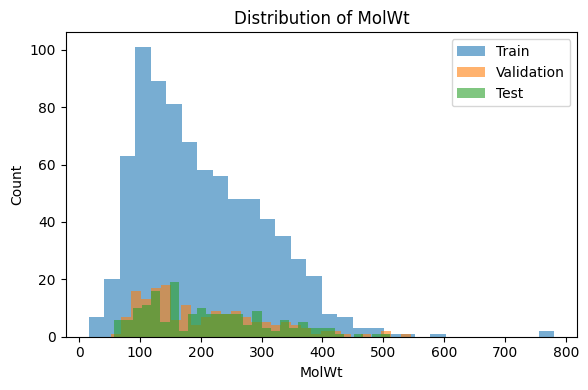

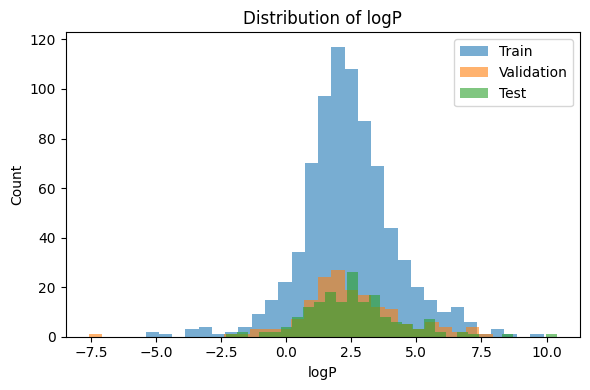

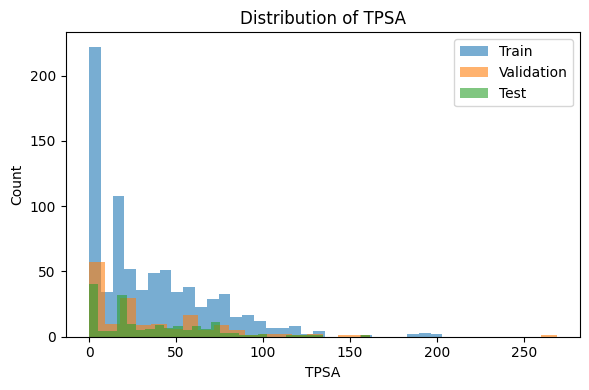

In [18]:
import matplotlib.pyplot as plt

# choose a consistent style
plt.style.use("default")

# define which descriptors to compare
features = ["MolWt", "logP", "TPSA"]

# plot histograms for each descriptor
for feat in features:
    plt.figure(figsize=(6,4))
    plt.hist(train_desc[feat].dropna(), bins=30, alpha=0.6, label="Train")
    plt.hist(valid_desc[feat].dropna(), bins=30, alpha=0.6, label="Validation")
    plt.hist(test_desc[feat].dropna(),  bins=30, alpha=0.6, label="Test")
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.title(f"Distribution of {feat}")
    plt.legend()
    plt.tight_layout()
    plt.show()


## A Simple Model: Linear Regression

We will start with the simplest possible machine-learning model — **Linear Regression**.

It assumes that solubility can be expressed as a linear combination of molecular descriptors:

$\text{logS} = a_0 + a_1 \cdot \text{MolWt} + a_2 \cdot \text{logP} + a_3 \cdot \text{TPSA} + \dots$


Each descriptor contributes additively, and the model learns the coefficients that best fit the data.

This model is easy to interpret — we can see which properties make a molecule **more** or **less** soluble.


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Define features and target
features = ["MolWt", "logP", "TPSA", "HBD", "HBA", "RotB"]
target = "logS_exp"

X_train = train_desc[features]
y_train = train_desc[target]
X_test  = test_desc[features]
y_test  = test_desc[target]

# Train linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Evaluate
y_pred = linreg.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Show coefficients
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": linreg.coef_
}).sort_values("Coefficient", ascending=False)

coef_df


R²: 0.7581403703119796
MAE: 0.7611211718049598


,Feature,Coefficient
4,HBA,0.114010
5,RotB,0.023502
0,MolWt,-0.003780
2,TPSA,-0.013336
3,HBD,-0.139115
1,logP,-0.961820


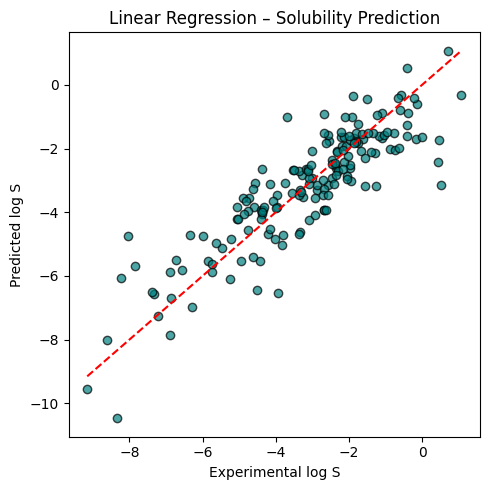

In [20]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor="k", color="teal")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Experimental log S")
plt.ylabel("Predicted log S")
plt.title("Linear Regression – Solubility Prediction")
plt.tight_layout()
plt.show()


## Random Forest Regression

Linear regression assumes a straight-line relationship between molecular descriptors and solubility.
But chemistry is often **nonlinear** — small structural changes can have large, unpredictable effects on solubility.

A **Random Forest Regressor** is an ensemble model that builds many small decision trees and averages their predictions.
Each tree captures different relationships, allowing the forest to model more complex patterns.

We will now train a Random Forest model on the same descriptors (excluding `logP`) and compare its performance.


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Same features as before (without logP for fair comparison)
features_rf = ["MolWt", "logP", "TPSA", "HBD", "HBA", "RotB"]
target = "logS_exp"

X_train = train_desc[features_rf]
y_train = train_desc[target]
X_test  = test_desc[features_rf]
y_test  = test_desc[target]

# Train a Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
print("R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))


R²: 0.8573710378130042
MAE: 0.525856292635632


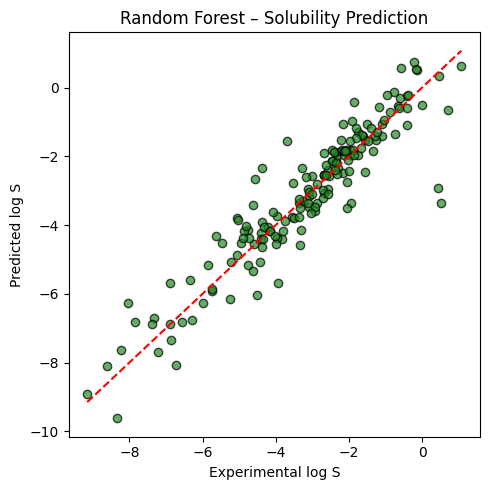

In [25]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_rf, alpha=0.7, edgecolor="k", color="forestgreen")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Experimental log S")
plt.ylabel("Predicted log S")
plt.title("Random Forest – Solubility Prediction")
plt.tight_layout()
plt.show()


## Gradient Boosting with XGBoost

A Random Forest builds many independent trees and averages their predictions.  
In contrast, **gradient boosting** builds trees *sequentially*, where each new tree focuses on correcting the errors of the previous ones.  

**XGBoost** (eXtreme Gradient Boosting) is a popular, efficient implementation of gradient boosting.  
It often achieves better performance than Random Forests, especially when you have many correlated features or nonlinear relationships.

We will train an `XGBRegressor` on our descriptors and see if it improves prediction of solubility.


In [26]:
!pip install -q xgboost


In [27]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error

# Select features (you could include logP or omit based on prior experiments)
features = ["MolWt", "logP", "TPSA", "HBD", "HBA", "RotB"]
target = "logS_exp"

X_train = train_desc[features]
y_train = train_desc[target]
X_test  = test_desc[features]
y_test  = test_desc[target]

# Create and train XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    objective="reg:squarederror",
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

# Predict & evaluate
y_pred = xgb_model.predict(X_test)
print("XGBoost R²:", r2_score(y_test, y_pred))
print("XGBoost MAE:", mean_absolute_error(y_test, y_pred))


XGBoost R²: 0.8585840675584514
XGBoost MAE: 0.5385383009204532
